In [ ]:
!pip3 install ktrain

In [ ]:
# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value) # tensorflow 2.x
# tf.set_random_seed(seed_value) # tensorflow 1.x

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
import ktrain
from ktrain import text

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_split.zip to data_split.zip


In [ ]:
! unzip 'data_split.zip'

In [ ]:
import pandas as pd

In [ ]:
TextList = [] #(filename, label, text)
path = 'dataset/train-data/'
import re
for label in os.listdir(path):
    for filename in os.listdir(path+label+'/'):
        file = path+label+'/'+filename
        try:
            with open(file, 'r') as f:
                text = f.readlines()
                parsetext = [] # list containing sentences
                for sentence in text:
                    if sentence == '\n':
                        pass
                    else:
                        for badcharacter in ['<B>\w{2}:', 'CC:', '<B>', '</B>', '\n']:
                            sentence = re.sub(badcharacter, '', sentence)
                        sentence = ''.join([s.lower() for s in sentence])
                        
                        parsetext.append(sentence)

            TextList.append((filename.strip('.txt'), label.strip(path), ''.join(parsetext)))
        except:
            pass

df = pd.DataFrame(TextList, columns = ['filename', 'label', 'text'])  
len(df)

811

In [ ]:
df['str_len'] = df['text'].str.len()
df = df[df['str_len'] != 0]

In [ ]:
from sklearn.preprocessing import LabelEncoder

#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["label2"] = le.fit_transform(df["label"])

In [ ]:
df["label2"].value_counts()

2    217
3    182
0    156
1    139
4    109
Name: label2, dtype: int64

## Split data into train, val and test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_testVal, y_train, y_testVal = train_test_split(df['text'], 
                                                    df['label'], 
                                                    test_size = 0.4,
                                                    random_state = 16,
                                                    stratify = df['label'])

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_testVal, 
                                                    y_testVal, 
                                                    test_size = 0.5,
                                                    random_state = 16,
                                                    stratify = y_testVal)

In [ ]:
#train
X_tr = X_train.values.tolist()
y_tr = y_train.values.tolist()

#val
X_val = X_val.values.tolist()
y_val = y_val.values.tolist()

#test
X_ts = X_test.values.tolist()
y_ts = y_test.values.tolist()

In [ ]:
label_list = df['label'].unique().tolist()
batch_size = 6

In [ ]:
label_list

['Orthopedic', 'Neurology', 'Urology', 'Radiology', 'Gastroenterology']

In [ ]:
from ktrain import text

## Bert

In [ ]:
MODEL_NAME = 'bert-base-uncased'
t_mod = text.Transformer(MODEL_NAME, maxlen=512, class_names=label_list)

# Pre-processing training & test data
train = t_mod.preprocess_train(X_tr,y_tr)
val = t_mod.preprocess_train(X_val,y_val)
test = t_mod.preprocess_train(X_ts,y_ts)

model = t_mod.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=batch_size)


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
80/80 [==============================] - 55s 465ms/step - loss: 1.6126 - accuracy: 0.2667
Epoch 2/1024
80/80 [==============================] - 37s 466ms/step - loss: 1.6035 - accuracy: 0.2653
Epoch 3/1024
80/80 [==============================] - 37s 461ms/step - loss: 1.5775 - accuracy: 0.3095
Epoch 4/1024
80/80 [==============================] - 37s 461ms/step - loss: 1.5058 - accuracy: 0.4084
Epoch 5/1024
80/80 [==============================] - 37s 461ms/step - loss: 1.4296 - accuracy: 0.4316
Epoch 6/1024
80/80 [==============================] - 37s 461ms/step - loss: 1.2723 - accuracy: 0.5053
Epoch 7/1024
80/80 [==============================] - 37s 461ms/step - loss: 0.9637 - accuracy: 0.6505
Epoch 8/1024
80/80 [==============================] - 37s 461ms/step - loss: 0.7452 - accuracy: 0.7284
Epoch 9/1024
80/80 [==============================] - 37s 461ms/step - loss: 0.7579 - accurac

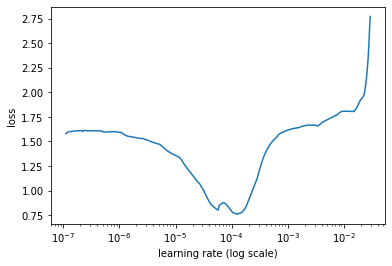

In [ ]:
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
81/81 [==============================] - 59s 551ms/step - loss: 1.4460 - accuracy: 0.4075 - val_loss: 1.0701 - val_accuracy: 0.6149
Epoch 2/1024
81/81 [==============================] - 41s 511ms/step - loss: 0.8284 - accuracy: 0.6902 - val_loss: 0.6882 - val_accuracy: 0.7640
Epoch 3/1024
81/81 [==============================] - 41s 510ms/step - loss: 0.6404 - accuracy: 0.7817 - val_loss: 0.6233 - val_accuracy: 0.7640
Epoch 4/1024
81/81 [==============================] - 41s 511ms/step - loss: 0.5354 - accuracy: 0.7879 - val_loss: 0.5853 - val_accuracy: 0.7764
Epoch 5/1024
81/81 [==============================] - 41s 507ms/step - loss: 0.5220 - accuracy: 0.7942 - val_loss: 0.6934 - val_accuracy: 0.7081
Epoch 6/1024
81/81 [==============================] - ETA: 0s - loss: 0.3729 - accuracy: 0

In [ ]:
learner.validate(val_data= test)

              precision    recall  f1-score   support

           0       0.89      0.77      0.83        31
           1       0.52      0.39      0.45        28
           2       0.82      0.84      0.83        43
           3       0.56      0.76      0.64        37
           4       0.95      0.82      0.88        22

    accuracy                           0.73       161
   macro avg       0.75      0.72      0.73       161
weighted avg       0.74      0.73      0.73       161



array([[24,  0,  1,  5,  1],
       [ 2, 11,  3, 12,  0],
       [ 0,  3, 36,  4,  0],
       [ 0,  6,  3, 28,  0],
       [ 1,  1,  1,  1, 18]])

In [ ]:
learner.autofit(5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
81/81 [==============================] - 42s 516ms/step - loss: 0.2279 - accuracy: 0.9002 - val_loss: 0.6444 - val_accuracy: 0.7516
Epoch 2/1024
81/81 [==============================] - 41s 510ms/step - loss: 0.2109 - accuracy: 0.9044 - val_loss: 0.6411 - val_accuracy: 0.7640
Epoch 3/1024
81/81 [==============================] - 41s 507ms/step - loss: 0.2145 - accuracy: 0.9023 - val_loss: 0.7914 - val_accuracy: 0.7391
Epoch 4/1024
81/81 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9127
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
81/81 [==============================] - 41s 507ms/step - loss: 0.2005 - accuracy: 0.9127 - val_loss: 0.8127 - val_accuracy: 0.7453
Epoch 5/1024
81/81 [==============================] - 41s 50

In [ ]:
learner.validate(val_data= test)

              precision    recall  f1-score   support

           0       0.92      0.71      0.80        31
           1       0.50      0.54      0.52        28
           2       0.87      0.79      0.83        43
           3       0.56      0.73      0.64        37
           4       0.95      0.86      0.90        22

    accuracy                           0.73       161
   macro avg       0.76      0.73      0.74       161
weighted avg       0.76      0.73      0.74       161



array([[22,  1,  1,  6,  1],
       [ 1, 15,  1, 11,  0],
       [ 0,  6, 34,  3,  0],
       [ 0,  7,  3, 27,  0],
       [ 1,  1,  0,  1, 19]])

## DistilBert

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
t_mod = text.Transformer(MODEL_NAME, maxlen=512, class_names=label_list)

# Pre-processing training & test data
train = t_mod.preprocess_train(X_tr,y_tr)
val = t_mod.preprocess_train(X_val,y_val)
test = t_mod.preprocess_train(X_ts,y_ts)

model = t_mod.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=batch_size)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 442
	95percentile : 1027
	99percentile : 1524


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 460
	95percentile : 1084
	99percentile : 1558


Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 451
	95percentile : 1014
	99percentile : 1518


Is Multi-Label? False


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
80/80 [==============================] - 28s 235ms/step - loss: 1.6181 - accuracy: 0.1667
Epoch 2/1024
80/80 [==============================] - 19s 237ms/step - loss: 1.6134 - accuracy: 0.1958
Epoch 3/1024
80/80 [==============================] - 19s 234ms/step - loss: 1.6055 - accuracy: 0.2505
Epoch 4/1024
80/80 [==============================] - 19s 235ms/step - loss: 1.5909 - accuracy: 0.2884
Epoch 5/1024
80/80 [==============================] - 19s 235ms/step - loss: 1.5344 - accuracy: 0.3895
Epoch 6/1024
80/80 [==============================] - 19s 234ms/step - loss: 1.2776 - accuracy: 0.5305
Epoch 7/1024
80/80 [==============================] - 19s 234ms/step - loss: 0.7913 - accuracy: 0.7389
Epoch 8/1024
80/80 [==============================] - 19s 234ms/step - loss: 0.5569 - accuracy: 0.8042
Epoch 9/1024
80/80 [==============================] - 19s 234ms/step - loss: 0.5805 - accurac

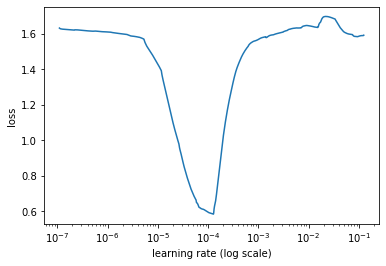

In [ ]:
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
81/81 [==============================] - 30s 279ms/step - loss: 1.2777 - accuracy: 0.4595 - val_loss: 0.7429 - val_accuracy: 0.7578
Epoch 2/1024
81/81 [==============================] - 21s 259ms/step - loss: 0.6330 - accuracy: 0.7838 - val_loss: 0.6359 - val_accuracy: 0.7640
Epoch 3/1024
81/81 [==============================] - 21s 259ms/step - loss: 0.4794 - accuracy: 0.8274 - val_loss: 0.5200 - val_accuracy: 0.7640
Epoch 4/1024
81/81 [==============================] - 21s 257ms/step - loss: 0.3631 - accuracy: 0.8399 - val_loss: 0.5274 - val_accuracy: 0.7888
Epoch 5/1024
81/81 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8628
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
81/81 [==============================] - 21s 257

In [ ]:
learner.validate(val_data= test)

              precision    recall  f1-score   support

           0       0.90      0.87      0.89        31
           1       0.68      0.61      0.64        28
           2       0.84      0.88      0.86        43
           3       0.61      0.68      0.64        37
           4       0.90      0.82      0.86        22

    accuracy                           0.78       161
   macro avg       0.79      0.77      0.78       161
weighted avg       0.78      0.78      0.78       161



array([[27,  0,  0,  3,  1],
       [ 0, 17,  3,  8,  0],
       [ 0,  1, 38,  4,  0],
       [ 0,  7,  4, 25,  1],
       [ 3,  0,  0,  1, 18]])

## Bio_ClinicalBERT

In [ ]:
MODEL_NAME = 'emilyalsentzer/Bio_ClinicalBERT'
t_mod = text.Transformer(MODEL_NAME, maxlen=512, class_names=label_list)

# Pre-processing training & test data
train = t_mod.preprocess_train(X_tr,y_tr)
val = t_mod.preprocess_train(X_val,y_val)
test = t_mod.preprocess_train(X_ts,y_ts)

model = t_mod.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=batch_size)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 442
	95percentile : 1027
	99percentile : 1524


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 460
	95percentile : 1084
	99percentile : 1558


Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 451
	95percentile : 1014
	99percentile : 1518


Is Multi-Label? False


404 Client Error: Not Found for url: https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/tf_model.h5
/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1069: UserWarning: Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn('Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. ' +\


Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
80/80 [==============================] - 51s 464ms/step - loss: 1.6538 - accuracy: 0.1979
Epoch 2/1024
80/80 [==============================] - 37s 465ms/step - loss: 1.6306 - accuracy: 0.2168
Epoch 3/1024
80/80 [==============================] - 37s 461ms/step - loss: 1.6131 - accuracy: 0.2484
Epoch 4/1024
80/80 [==============================] - 37s 461ms/step - loss: 1.5560 - accuracy: 0.3432
Epoch 5/1024
80/80 [==============================] - 37s 460ms/step - loss: 1.4830 - accuracy: 0.4463
Epoch 6/1024
80/80 [==============================] - 37s 460ms/step - loss: 1.1843 - accuracy: 0.6189
Epoch 7/1024
80/80 [==============================] - 37s 460ms/step - loss: 0.6708 - accuracy: 0.7726
Epoch 8/1024
80/80 [==============================] - 37s 461ms/step - loss: 0.4911 - accuracy: 0.8211
Epoch 9/1024
80/80 [==============================] - 37s 461ms/step - loss: 0.6840 - accurac

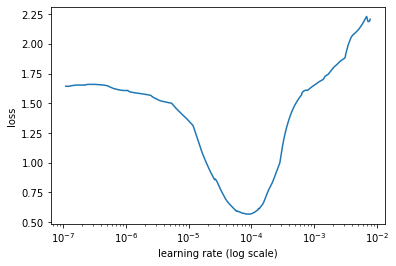

In [ ]:
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
81/81 [==============================] - 58s 549ms/step - loss: 1.1737 - accuracy: 0.5094 - val_loss: 0.6756 - val_accuracy: 0.7888
Epoch 2/1024
81/81 [==============================] - 41s 506ms/step - loss: 0.5606 - accuracy: 0.8087 - val_loss: 0.7323 - val_accuracy: 0.7516
Epoch 3/1024
81/81 [==============================] - 41s 510ms/step - loss: 0.5319 - accuracy: 0.8046 - val_loss: 0.6139 - val_accuracy: 0.7453
Epoch 4/1024
81/81 [==============================] - 41s 510ms/step - loss: 0.4302 - accuracy: 0.8274 - val_loss: 0.6017 - val_accuracy: 0.7888
Epoch 5/1024
81/81 [==============================] - 41s 506ms/step - loss: 0.4087 - accuracy: 0.8295 - val_loss: 0.6883 - val_accuracy: 0.7391
Epoch 6/1024
81/81 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0

In [ ]:
learner.validate(val_data= test)

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        31
           1       0.67      0.57      0.62        28
           2       0.91      0.91      0.91        43
           3       0.57      0.73      0.64        37
           4       0.91      0.95      0.93        22

    accuracy                           0.79       161
   macro avg       0.81      0.79      0.79       161
weighted avg       0.81      0.79      0.79       161



array([[24,  1,  0,  4,  2],
       [ 0, 16,  1, 11,  0],
       [ 0,  0, 39,  4,  0],
       [ 0,  7,  3, 27,  0],
       [ 0,  0,  0,  1, 21]])

longformer

In [ ]:
MODEL_NAME = 'allenai/longformer-base-4096'
t_mod = text.Transformer(MODEL_NAME, maxlen=1024, class_names=label_list)

# Pre-processing training & test data
train = t_mod.preprocess_train(X_tr,y_tr)
val = t_mod.preprocess_train(X_val,y_val)
test = t_mod.preprocess_train(X_ts,y_ts)

model = t_mod.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=1)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:864: UserWarning: Transformer models typically only support maxlen <= 512, unless you are using certain models like the Longformer.
  if maxlen > 512: warnings.warn('Transformer models typically only support maxlen <= 512, unless you are using certain models like the Longformer.')


preprocessing train...
language: en
train sequence lengths:
	mean : 442
	95percentile : 1027
	99percentile : 1524


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 460
	95percentile : 1084
	99percentile : 1558


Is Multi-Label? False
preprocessing train...
language: en
train sequence lengths:
	mean : 451
	95percentile : 1014
	99percentile : 1518


Is Multi-Label? False


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
240/240 [==============================] - 244s 712ms/step - loss: 1.6426 - accuracy: 0.1979
Epoch 2/1024
240/240 [==============================] - 171s 712ms/step - loss: 1.5714 - accuracy: 0.2443
Epoch 3/1024
240/240 [==============================] - 171s 713ms/step - loss: 1.1737 - accuracy: 0.4948
Epoch 4/1024
240/240 [==============================] - 171s 711ms/step - loss: 1.6673 - accuracy: 0.2192
Epoch 5/1024
240/240 [==============================] - 171s 712ms/step - loss: 4.7028 - accuracy: 0.2067
Epoch 6/1024
240/240 [==============================] - 2s 6ms/step - loss: 17.5506 - accuracy: 0.0000e+00


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


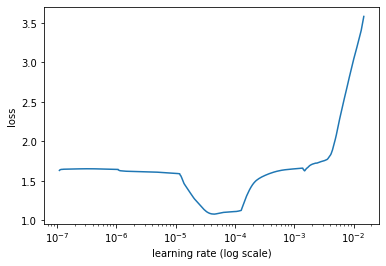

In [ ]:
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.autofit(1e-4, epochs=3)

In [ ]:
learner.validate(val_data= test)

## Run prediction

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
t_mod = text.Transformer(MODEL_NAME, maxlen=512, class_names=label_list)

# Pre-processing training & test data
train = t_mod.preprocess_train(X_tr,y_tr)
val = t_mod.preprocess_train(X_val,y_val)
test = t_mod.preprocess_train(X_ts,y_ts)

model = t_mod.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=batch_size)

In [ ]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
81/81 [==============================] - 33s 286ms/step - loss: 1.2294 - accuracy: 0.4990 - val_loss: 0.7243 - val_accuracy: 0.7764
Epoch 2/1024
81/81 [==============================] - 21s 262ms/step - loss: 0.6582 - accuracy: 0.7568 - val_loss: 0.6239 - val_accuracy: 0.7391
Epoch 3/1024
81/81 [==============================] - 21s 262ms/step - loss: 0.4681 - accuracy: 0.8108 - val_loss: 0.6020 - val_accuracy: 0.7516
Epoch 4/1024
81/81 [==============================] - 21s 261ms/step - loss: 0.3524 - accuracy: 0.8586 - val_loss: 0.5910 - val_accuracy: 0.7516
Epoch 5/1024
81/81 [==============================] - 21s 259ms/step - loss: 0.3129 - accuracy: 0.8732 - val_loss: 0.7361 - val_accuracy: 0.7329
Epoch 6/1024
81/81 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t_mod)

In [ ]:
predictor.predict_proba(df.iloc[38]['text'])

array([0.01907129, 0.05906139, 0.19061849, 0.71930933, 0.01193945],
      dtype=float32)

In [ ]:
predictor.predict(df.iloc[38]['text'])

'Radiology'

In [ ]:
df.iloc[38]['text']

'exam:  three views of the right ankle.indications:  pain.findings:  three views of the right ankle are obtained.  there is no evidence of fractures or dislocations.  no significant degenerative changes or destructive osseous lesions of the ankle are noted.  there is a small plantar calcaneal spur.  there is no significant surrounding soft tissue swelling.impression:  negative right ankle.'

In [ ]:
predictor.predict_proba(df.iloc[220]['text'])

array([0.00655892, 0.70558697, 0.01900911, 0.26366922, 0.00517576],
      dtype=float32)

In [ ]:
predictor.predict(df.iloc[220]['text'])

'Neurology'

In [ ]:
df.iloc[220]['text']

'history of present illness:  the patient comes in today because of feeling lightheaded and difficulty keeping his balance.  he denies this as a spinning sensation that he had had in the past with vertigo.  he just describes as feeling very lightheaded.  it usually occurs with position changes such as when he stands up from the sitting position or stands up from a lying position.  it tends to ease when he sits down again, but does not totally resolve for another 15 to 30 minutes and he feels shaky and weak all over.  lorazepam did not help this sensation.  his blood pressure has been up lately and his dose of metoprolol was increased.  they feel these symptoms have gotten worse since metoprolol was increased.past medical history:  detailed on our h&p form.  positive for elevated cholesterol, diabetes, glaucoma, cataracts, hypertension, heart disease, vertigo, stroke in may of 2005, congestive heart failure, cabg, and cataract removed right eye.current medications:  detailed on the h&p 

In [ ]:
# predictor.save("./verana/medical_notes_classifier_basebert")

In [ ]:
#predictor = ktrain.load_predictor("./verana/medical_notes_classifier_basebert")